In [1]:
library(gridExtra)
library(matrixStats)
library(dplyr)
library(rlang)
library(reshape2)
library(clusterCrit)
library(grid)
library(ggrepel)
library(RColorBrewer)
library(dplyr)
library(IRdisplay)
library(scales)
library(survival)
library(corrplot)
library(Hmisc)
library(ggplot2)
library(survminer)
library(muhaz)
library(dplyr)
library(stringr)
library(dummies)
library(miceadds)
options(warn=-1)
library(data.table)
library(tidyr)

source('../../../../src/tools.R')     # custom tools function
source('../../../../src/hdp_tools_yanis.R')
source("../../../../src/merge_df.R")
source("../../../../src/my_toolbox.R")
source("../../../../src/my_components.R")
source("../../../../src/my_utils.R")
source("../../../../src/ggstyles.R")
source("../../../../src/my_hotspots.R")
###


theme_set(theme_minimal())

# set jupyer notebook parameters
options(repr.plot.res        = 100, # set a medium-definition resolution for the jupyter notebooks plots (DPI)
        repr.matrix.max.rows = 200, # set the maximum number of rows displayed
        repr.matrix.max.cols = 200) # set the maximum number of columns displayed



Attaching package: ‘dplyr’

The following object is masked from ‘package:matrixStats’:

    count

The following object is masked from ‘package:gridExtra’:

    combine

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2

Attaching package: ‘survival’

The following object is masked from ‘package:clusterCrit’:

    concordance

corrplot 0.84 loaded
Loading required package: lattice
Loading required package: Formula

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    src, summarize

The following objects are masked from ‘package:base’:

    format.pval, units

Loading required package: ggpubr
Loading required package: magrittr

Attaching package: ‘magrittr’

The following object is masked from ‘package:rlang’:

    set_names

dummies-1.5.6 provided by Decision Patterns

Loading required package: mice

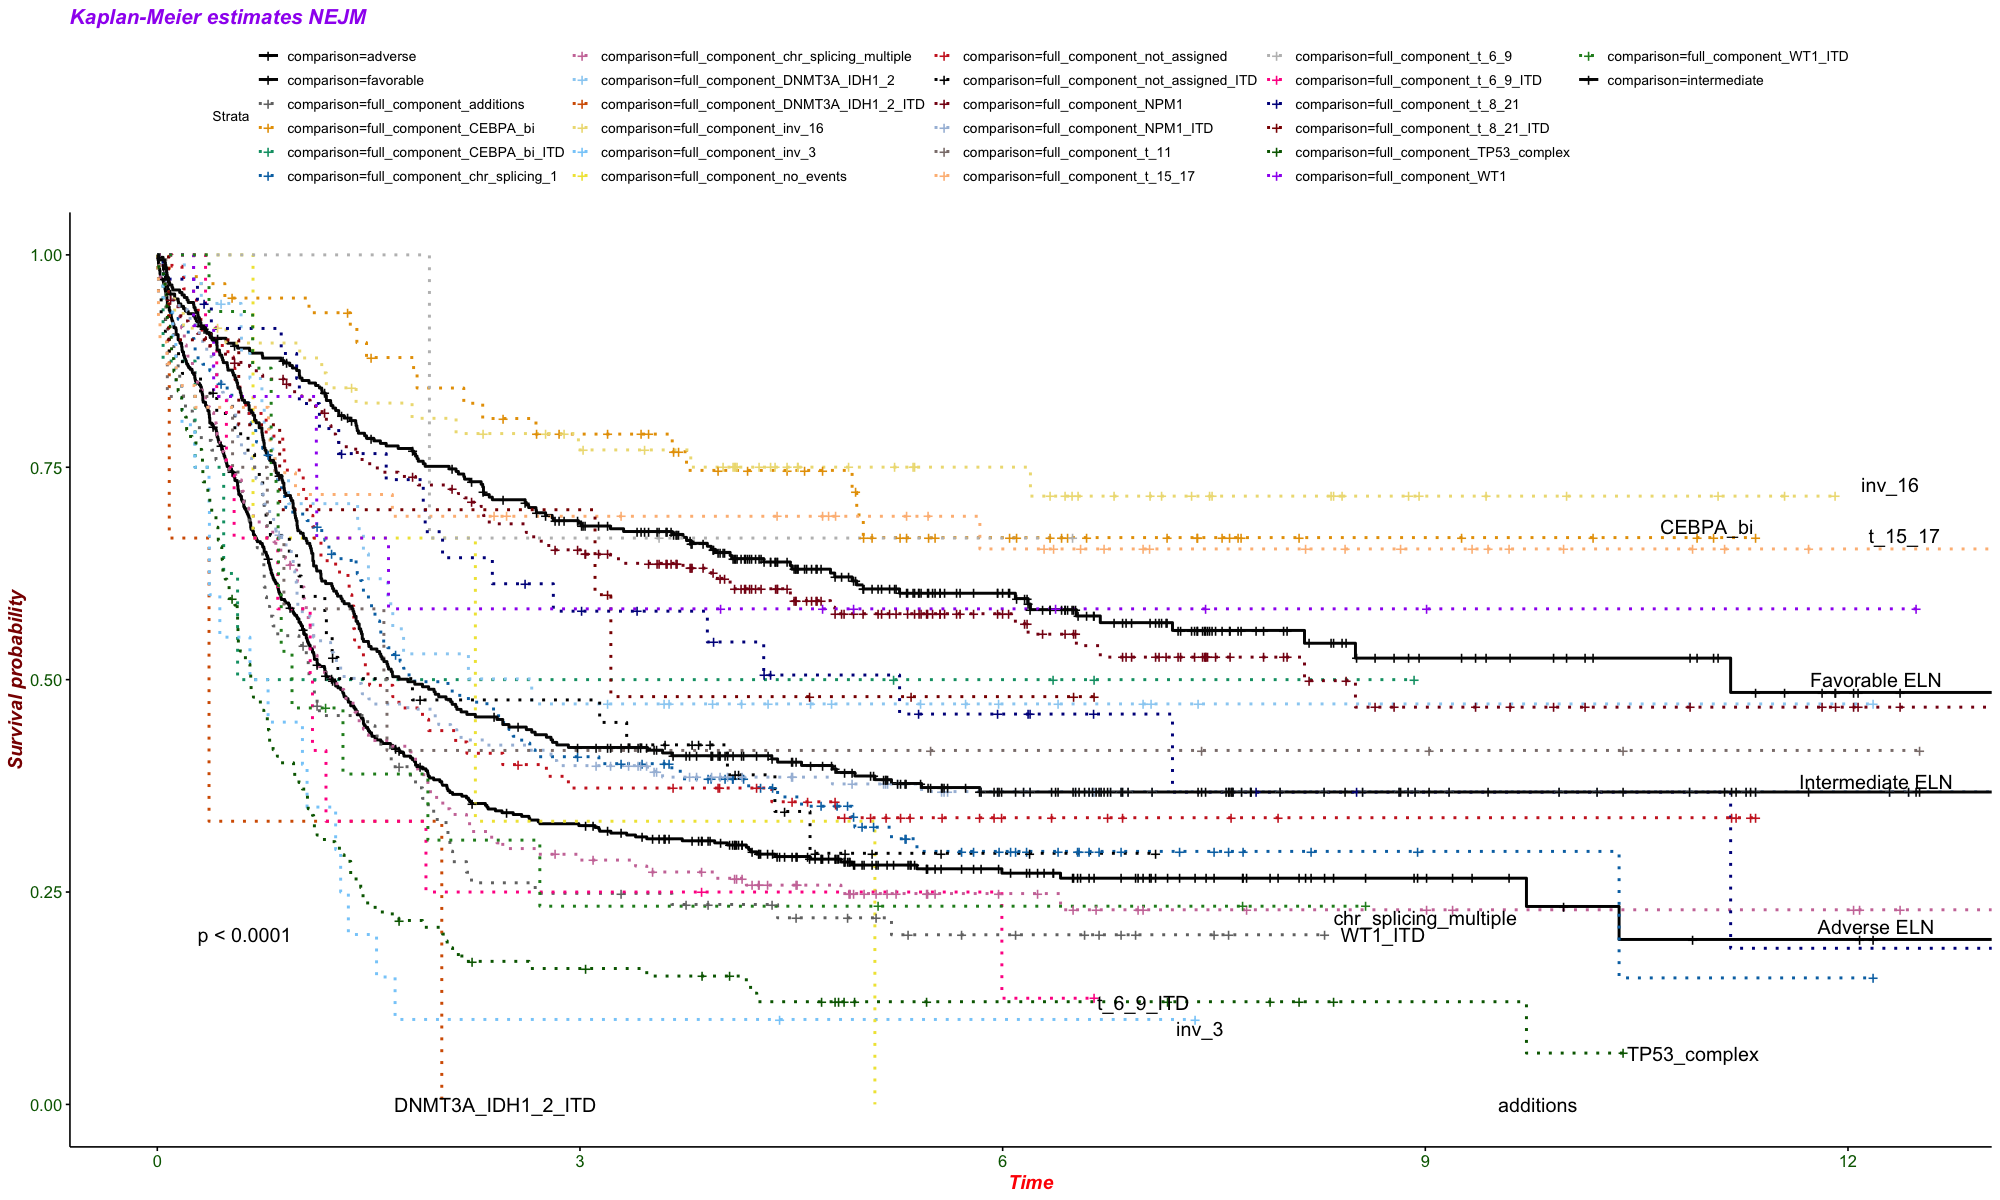

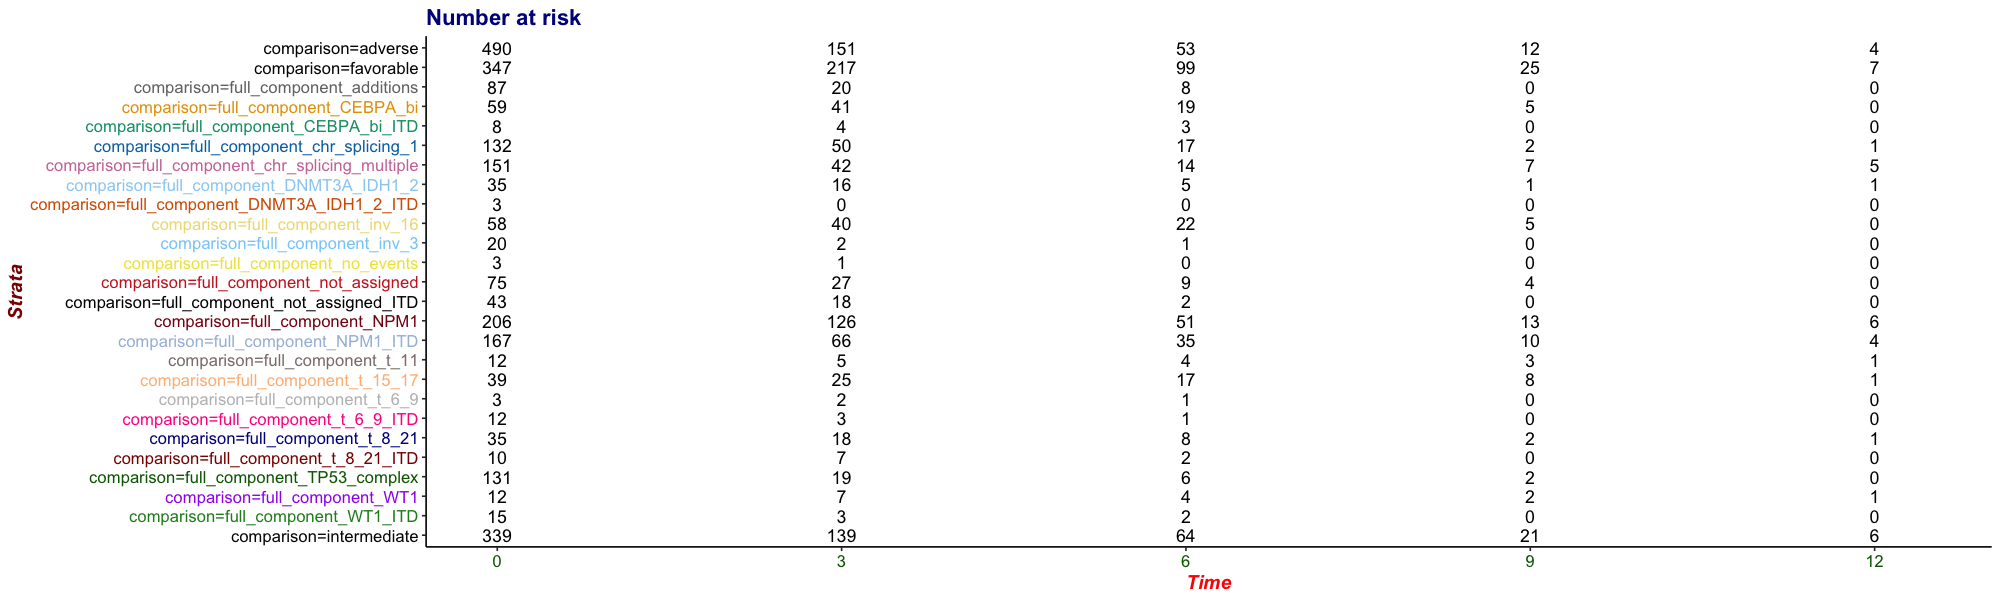

In [2]:

df_w_correlates <- read.table("full_data_validation.tsv")
df_final <- read.table("full_data_validation.tsv")
cols_component <- colnames(df_final %>% dplyr:: select(starts_with("full_component_")))
colors <- c("black","gray1","grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7",
        "#9ad0f3", "#D55E00", 
        "lightgoldenrod","lightskyblue","#F0E442",
        "firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen","purple","forestgreen","gray2")
tmp1 <- NULL
for (comp in cols_component){
    tmp2 <- df_w_correlates[df_w_correlates[,comp]==1,]
    tmp2$comparison <- comp
    tmp1 <- rbind(tmp1,tmp2)
    }

tmp2 <- df_w_correlates
tmp2$comparison <- tmp2$eln_2017
                          
tmp1 <- rbind(tmp1,tmp2)
surv_object <- Surv(time = tmp1$OS, event = tmp1$OS_Status)
fit <- survfit(surv_object ~ comparison, data = tmp1)
p <- ggsurvplot(fit,  pval = TRUE,main = "Survival curve",risk.table=T,submain = "Kaplan-Meier estimates NEJM",palette=colors,linetype=c(1,1,rep(3,23),1),xlim=c(0,12.4),break.time.by=3,
                  ggtheme = theme_survminer(
                 font.main = c(16, "bold", "darkblue"),
                 font.submain = c(15, "bold.italic", "purple"),
                 font.caption = c(14, "plain", "orange"),
                 font.x = c(14, "bold.italic", "red"),
                 font.y = c(14, "bold.italic", "darkred"),
                 font.tickslab = c(12, "plain", "darkgreen")))

set_notebook_plot_size(20,12)
# p$plot
p$plot + ggplot2::annotate("text", 
                                x = c(9.8,10.9,2.4,7.4,7,8.7,9,12.3,11,12.4,12.2,12.2,12.2),y=c(0,0.06,0,0.09,0.12,0.2,0.22,0.73,0.68,0.67,0.5,0.38,0.21),
                                label = c("additions","TP53_complex","DNMT3A_IDH1_2_ITD","inv_3","t_6_9_ITD","WT1_ITD","chr_splicing_multiple","inv_16","CEBPA_bi","t_15_17","Favorable ELN","Intermediate ELN","Adverse ELN"), size = 5)
set_notebook_plot_size(20,6)
p$table

In [15]:
library(glmnet)
library(doMC)
library(survival)
library(data.table)
library(mltools)
library(CoxBoost)
library(randomForestSRC)
library(CoxHD)
source('../../tools_prognosis/run_prognosis.R')



eln <- c(113,114,115)
comp <- c(89:112)
age <- c(84)

all_gen <- c(1:57)
vect <- apply(X=df_final[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
gen <- match(names(vect[vect>=2]),names(df_final))
              
all_cyto <- c(58:80)
vect <- apply(X=df_final[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df_final)[1])
cyto <- match(names(vect[vect>=2]),names(df_final))
              
clin <- c(85:87)
demo <- c(83,84)
demo_without_age <-c(83)
           
                          
                          
eln_comp <- c(eln,comp)          
eln_gen <- c(eln,gen)
eln_cyto <- c(eln,cyto)
eln_clin <- c(eln,clin)
eln_demo <- c(eln,demo)

# USEFUL FOR ELN COMPARISON
# with comp
eln_comp_gen <- c(eln_comp,gen)
eln_comp_cyto <- c(eln_comp,cyto)
eln_comp_clin <- c(eln_comp,clin)
eln_comp_demo <- c(eln_comp,demo)


eln_comp_gen_cyto <- c(eln_comp_gen,cyto)
eln_comp_gen_clin <- c(eln_comp_gen,clin)
eln_comp_gen_demo <- c(eln_comp_gen,demo)

eln_comp_cyto_clin <- c(eln_comp_cyto,clin)
eln_comp_cyto_demo <- c(eln_comp_cyto,demo)

eln_comp_clin_demo <- c(eln_comp_clin,demo)

eln_comp_gen_cyto_clin_demo <- c(eln_comp_gen_cyto,clin,demo)
eln_comp_gen_cyto_clin_demo_without_age <- c(eln_comp_gen_cyto,clin,demo_without_age)
              


# without comp


eln_gen_cyto <- c(eln_gen,cyto)
eln_clin_demo <- c(eln_clin,demo)
eln_clin <- c(eln,clin)
eln_demo <- c(eln,demo)

eln_gen_cyto_clin_demo <- c(eln_gen_cyto,clin,demo)

# USEFUL FOR COMP
comp_gen <- c(comp,gen)
comp_cyto <- c(comp,cyto)
comp_clin <- c(comp,clin)
comp_demo <- c(comp,demo)
comp_gen_cyto <- c(comp_gen,cyto)
comp_clin_demo <- c(comp_clin,demo)
comp_clin <- c(comp,clin)
comp_demo <- c(comp,demo)
comp_gen_cyto_clin_demo <- c(comp_gen_cyto,clin,demo)

#USEFUL FOR GEN
gen_cyto <- c(gen,cyto)
gen_clin <- c(gen,clin)
gen_demo <- c(gen,demo)
gen_clin_demo <- c(gen_clin,demo)
gen_cyto_clin_demo <- c(gen_cyto,clin,demo)

#USEFUL FOR CYTO 
cyto_clin <- c(cyto,clin)
cyto_demo <- c(cyto,demo)
cyto_clin_demo <- c(cyto_clin,demo)
cyto_gen_demo <- c(gen_cyto,demo)

clin_demo <-c(clin,demo)



y <- data.matrix(df_final[,c("OS","OS_Status")])

prognosis_features<- list(eln=c(gen_cyto))
                          
                          

predictors <- c(rep(list(predictorGLM),6))
str_predictors <-c(rep("CoxGLM",6),rep("RFS",1),"CoxBoost","RFX")
l_alpha <-seq(0,1,0.2)
l_ntree <- c(1050)
mc.cores <- 30
nodesize <- c(20)
for (i in 1:length(prognosis_features)){
    print("DONE")
    x <- data.matrix(df_final[,prognosis_features[[i]]])
    results <- launch_prognosis(x=x,y=y,predictors=predictors,str_predictors=str_predictors,l_alpha=l_alpha,nrepeats=5,
                l_ntree=l_ntree,mc.cores=mc.cores,nodesize=nodesize)
    print("DONE")
    }

[1] "DONE"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "start CV"
[1] "DONE"


In [5]:
colMeans(results)

CoxGLM_0 CoxGLM_0.2 CoxGLM_0.4 CoxGLM_0.6 CoxGLM_0.8   CoxGLM_1 
 0.6311214  0.6308857  0.6311607  0.6312382  0.6314748  0.6317149

In [14]:
colMeans(results)

CoxGLM_0 CoxGLM_0.2 CoxGLM_0.4 CoxGLM_0.6 CoxGLM_0.8   CoxGLM_1 
 0.6410752  0.6438731  0.6431673  0.6428858  0.6426534  0.6424580

In [17]:
colMeans(results)

CoxGLM_0 CoxGLM_0.2 CoxGLM_0.4 CoxGLM_0.6 CoxGLM_0.8   CoxGLM_1 
 0.6424765  0.6407539  0.6403005  0.6401371  0.6403048  0.6397720